### Imports


In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import requests
import pandas as pd
import numpy as np

## Convert CSV data to JSON format


In [98]:
plants_df = pd.read_csv("../data/transformed_data.csv")
plants_df.to_json("../data/plants.json", orient="records")

## Constants


### Paths to the qrels files and qrels Solr query urls


In [99]:
QREL1_FILE = "../qrels/q1.txt"
QREL2_FILE = "../qrels/q2.txt"
QREL3_FILE = "../qrels/q3.txt"
QREL4_FILE = "../qrels/q4.txt"

# winter plants
QREL1_SIMPLE_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=OR&q=%22low%20temperature*%22%20%22benefic%20*%20cold%22%20%22tolerant%20*%20cold%22%20%22remains%20*%20cold%22&qf=Introduction%20Description%20Characteristics%20Ecology&rows=30&useParams="
QREL1_BOOSTED_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=OR&q=%22low%20temperature*%22~3%20%22benefic%20cold%22~3%20%22tolerant%20cold%22~3%20%22remains%20cold%22~3&qf=Introduction%5E2%20Description%5E3%20Characteristics%20Ecology%5E0.7&rows=30&useParams="

# purple plants
QREL2_SIMPLE_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=AND&q=purple%20flowers%20species&qf=Introduction%20Description%20Characteristics&useParams="
QREL2_BOOSTED_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=AND&q=%22purple%20flowers%22~5%20species%20purple%5E5&qf=Introduction%20Description%5E3%20Characteristics&useParams="

# fruit trees
QREL3_SIMPLE_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=AND&q=fruit%20trees%20edible&qf=Name%20Description%20Introduction&useParams="
QREL3_BOOSTED_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=OR&q=fruit%5E5%20trees%20edible%5E2&qf=Description%5E2%20Introduction%20Characteristics&useParams="

# christmas
QREL4_SIMPLE_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=OR&q=Christmas%20OR%20celebration%20decoration%20OR%20season%20OR%20tradition%20OR%20ornamental&qf=Introduction%20Description%20Etymology&useParams="
QREL4_BOOSTED_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=OR&q=(%22Christmas%20celebration%22~2)%5E10%20OR%20(%22Christmas%20decoration%22~2)%5E10%20OR%20(%22Christmas%20season%22~2)%5E10%20OR%20tradition%20OR%20ornamental&qf=Introduction%20Description%20Etymology&rows=5&useParams="

### Store all info


In [100]:
info = {
    "qrel_1": {
        "qrels_file": QREL1_FILE,
        "simple_query_url": QREL1_SIMPLE_URL,
        "boosted_query_url": QREL1_BOOSTED_URL,
    },
    "qrel_2": {
        "qrels_file": QREL2_FILE,
        "simple_query_url": QREL2_SIMPLE_URL,
        "boosted_query_url": QREL2_BOOSTED_URL,
    },
    "qrel_3": {
        "qrels_file": QREL3_FILE,
        "simple_query_url": QREL3_SIMPLE_URL,
        "boosted_query_url": QREL3_BOOSTED_URL,
    },
    "qrel_4": {
        "qrels_file": QREL4_FILE,
        "simple_query_url": QREL4_SIMPLE_URL,
        "boosted_query_url": QREL4_BOOSTED_URL,
    },
}

## Calculate Precision-Recall


In [101]:
def calculate_precision_recall(results, relevant):
    # Calculate precision and recall values as we move down the ranked list
    precision_values = [
        len([doc for doc in results[:idx] if doc["Name"] in relevant]) / idx
        for idx, _ in enumerate(results, start=1)
    ]

    recall_values = [
        len([doc for doc in results[:idx] if doc["Name"] in relevant]) / len(relevant)
        for idx, _ in enumerate(results, start=1)
    ]

    precision_recall_match = {k: v for k, v in zip(recall_values, precision_values)}

    # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
    recall_values.extend(
        [step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values]
    )
    recall_values = sorted(set(recall_values))  # Sort the values

    # Extend matching dict to include these new intermediate steps
    for idx, step in enumerate(recall_values):
        if step not in precision_recall_match:
            if recall_values[idx - 1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[
                    recall_values[idx - 1]
                ]
            else:
                precision_recall_match[step] = precision_recall_match[
                    recall_values[idx + 1]
                ]

    return precision_recall_match, recall_values

## METRICS TABLE

In [102]:
def calculate_metrics(results, relevant):
    # Calculate metrics and create DataFrame
    metrics = {}
    metric = lambda f: metrics.setdefault(f.__name__, f)

    @metric
    def ap(results, relevant):
        """Average Precision"""
        precision_values = []
        relevant_count = 0

        for idx, doc in enumerate(results):
            if doc['Name'] in relevant:
                relevant_count += 1
                precision_at_k = relevant_count / (idx + 1)
                precision_values.append(precision_at_k)

        if not precision_values:
            return 0.0

        return sum(precision_values)/len(precision_values)

    
    @metric
    def p10(results, relevant, n=10):
        """Precision at N"""
        return len([doc for doc in results[:n] if doc['Name'] in relevant])/n

    def calculate_metric(key, results, relevant):
        return metrics[key](results, relevant)

    # Define metrics to be calculated
    evaluation_metrics = {
        'ap': 'Average Precision',
        'p10': 'Precision at 10 (P@10)'
    }

    # Calculate all metrics and export results as LaTeX table
    df = pd.DataFrame([['Metric','Value']] +
        [
            [evaluation_metrics[m], calculate_metric(m, results, relevant)]
            for m in evaluation_metrics
        ]
    )
    return df

In [103]:
def calculate_metrics_p30(results, relevant):
    # Calculate metrics and create DataFrame
    metrics = {}
    metric = lambda f: metrics.setdefault(f.__name__, f)

    @metric
    def ap(results, relevant):
        """Average Precision"""
        precision_values = []
        relevant_count = 0

        for idx, doc in enumerate(results):
            if doc['Name'] in relevant:
                relevant_count += 1
                precision_at_k = relevant_count / (idx + 1)
                precision_values.append(precision_at_k)

        if not precision_values:
            return 0.0

        return sum(precision_values)/len(precision_values)

    
    @metric
    def p30(results, relevant, n=30):
        """Precision at N"""
        return len([doc for doc in results[:n] if doc['Name'] in relevant])/n

    def calculate_metric(key, results, relevant):
        return metrics[key](results, relevant)

    # Define metrics to be calculated
    evaluation_metrics = {
        'ap': 'Average Precision',
        'p30': 'Precision at 30 (P@30)'
    }

    # Calculate all metrics and export results as LaTeX table
    df = pd.DataFrame([['Metric','Value']] +
        [
            [evaluation_metrics[m], calculate_metric(m, results, relevant)]
            for m in evaluation_metrics
        ]
    )
    return df

## PRECISION-RECALL CURVE

In [104]:
def generate_plots(precision_recall_match, recall_values, query_name, type):
    # Plot precision-recall curve
    disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
    disp.plot()
    plt.title(f"{query_name} {type} Precision-Recall Curve")
    plt.ylim(-0.1, 1.1)  # Set y-axis limits from 0 to 1
    # plt.savefig(f'{query_name}_{query_type}_precision_recall.pdf')

## OUTPUTS

[{'Name': 'Azolla caroliniana', 'Introduction': 'Azolla cristata , the Carolina mosquitofern, Carolina azolla or water velvet, is a species of Azolla native to the Americas, in eastern North America from southern Ontario southward, and from the east coast west to Wisconsin and Texas, and in the Caribbean, and in Central and South America from southeastern Mexico (Chiapas) south to northern Argentina and Uruguay.It is a freshwater aquatic fern, with scale-like fronds 5–10\xa0mm long, green to reddish, most often reddish in strong light and in winter. They are covered in tiny protuberances called trichomes that give it the appearance of velvet. It is able to fix nitrogen from the air by means of symbiotic cyanobacteria. It can survive winter water temperatures of 5\xa0°C (41\xa0°F), with optimum summer growth between 25–30\xa0°C (77–86\xa0°F).', 'Kingdom': 'Plantae', 'Division': 'Polypodiophyta', 'Class': 'Polypodiopsida', 'Clade': 'Tracheophytes', 'Order': 'Salviniales', 'Family': 'Salv

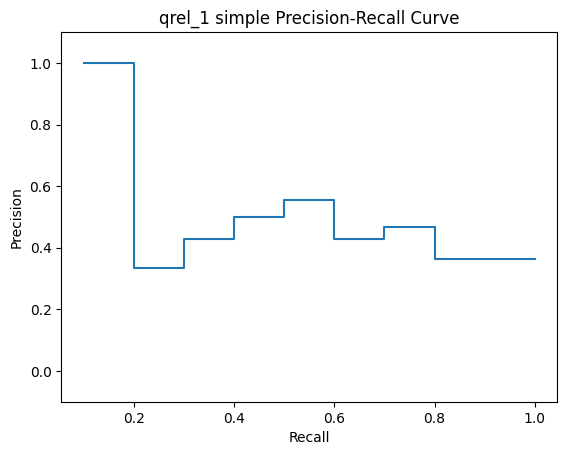

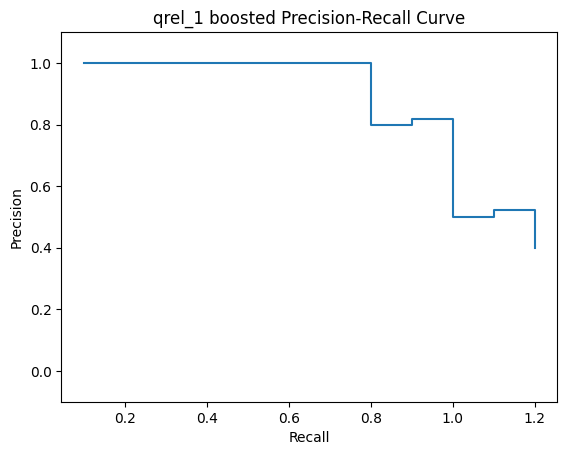

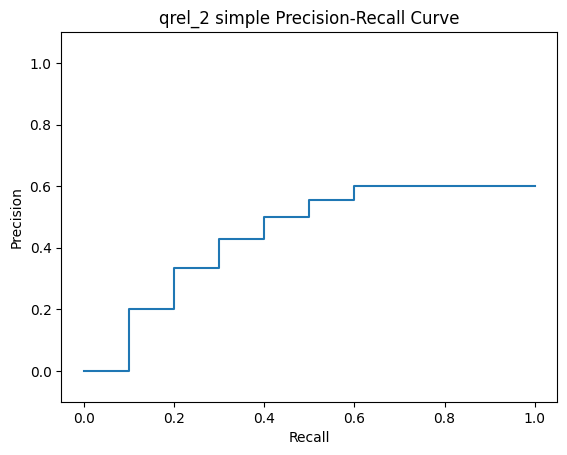

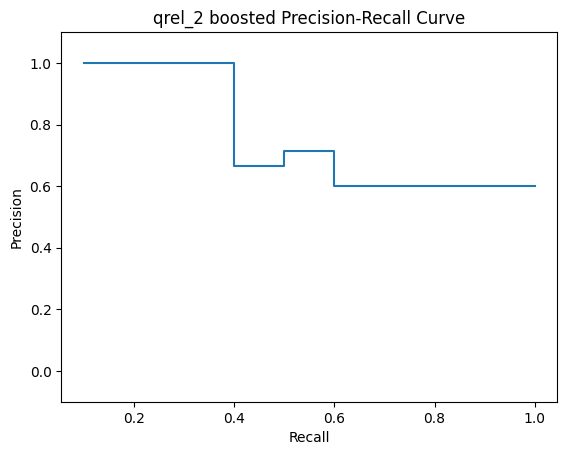

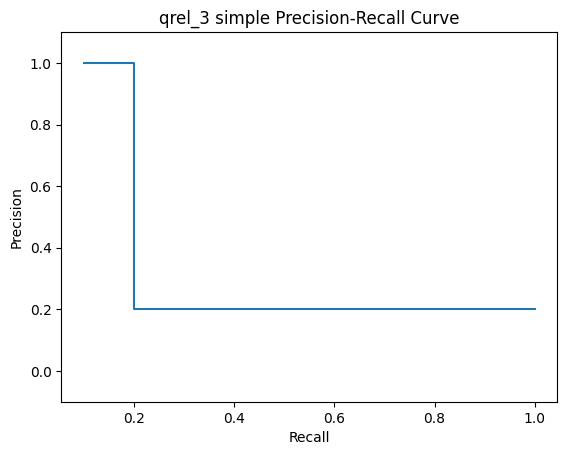

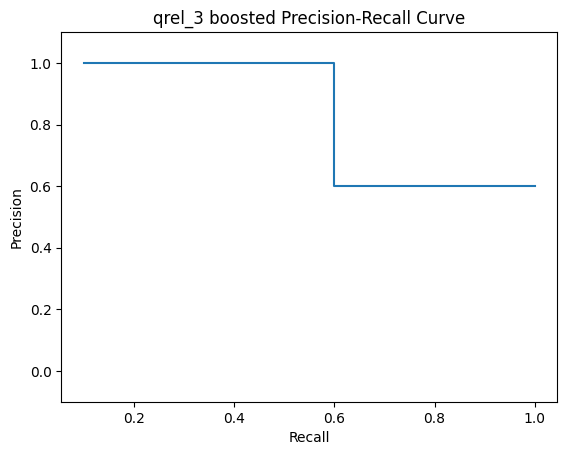

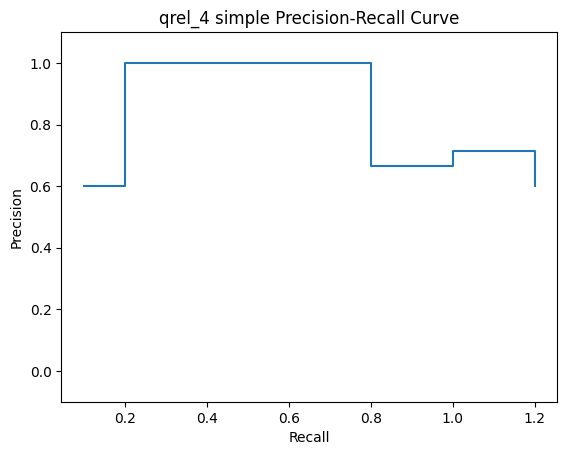

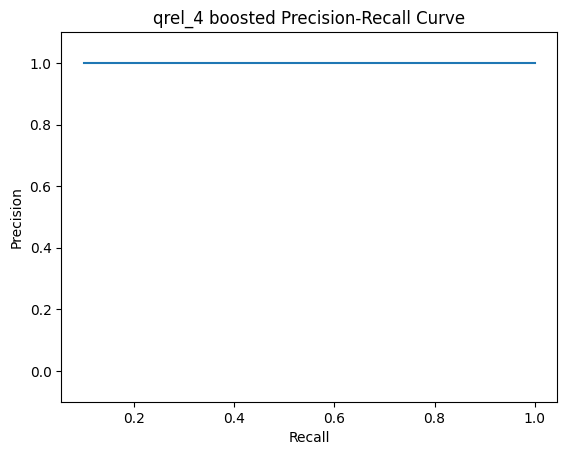

In [105]:
for query_name, query_info in info.items():
    # Read qrels to extract relevant documents
    relevant = list(map(lambda el: el.strip(), open(query_info["qrels_file"]).readlines()))

    # Get query results from Solr instance for both simple and boosted queries
    simple_results = requests.get(query_info["simple_query_url"]).json()['response']['docs']
    boosted_results = requests.get(query_info["boosted_query_url"]).json()['response']['docs']

    # Calculate precision-recall values for both simple and boosted queries
    simple_precision_recall_match, recall_values_simple = calculate_precision_recall(simple_results, relevant)
    boosted_precision_recall_match, recall_values_boosted = calculate_precision_recall(boosted_results, relevant)

    # Generate plots for both simple and boosted queries
    generate_plots(simple_precision_recall_match, recall_values_simple, query_name, "simple")
    generate_plots(boosted_precision_recall_match, recall_values_boosted, query_name, "boosted")

    # Calculate metrics for both simple and boosted queries and export results as LaTeX tables
    print(simple_results, relevant)
    if query_name == 'qrel_1':
        df_simple_metrics = calculate_metrics_p30(simple_results, relevant)
        df_boosted_metrics = calculate_metrics_p30(boosted_results, relevant)
    else:
        df_simple_metrics = calculate_metrics(simple_results, relevant)
        df_boosted_metrics = calculate_metrics(boosted_results, relevant)

    with open(f'./results/{query_name}_simple_results.tex','w') as tf_simple:
        tf_simple.write(df_simple_metrics.to_latex())

    with open(f'./results/{query_name}_boosted_results.tex','w') as tf_boosted:
        tf_boosted.write(df_boosted_metrics.to_latex())